# Analysis of acquired landmark - target data

### Loading the data and checking for inconsistencies 

In [22]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data -- this will have to include loading multipel data files in order to compare different patients
with open('../data/dataset_0.json') as f:
    data = json.load(f)

# Load screen details
with open('../data/screen_details_0.json') as f:
    screen_details = json.load(f)

records = []
for grid_size, points in data.items():
    if grid_size in ['3x3', '5x5']:
        for point_data in points:
            if point_data['landmarks']:
                records.append({
                    'grid_size': grid_size,
                    'point_x': point_data['point'][0],
                    'point_y': point_data['point'][1],
                    'distance': point_data['distance'],
                    'landmarks': np.array([list(landmark.values()) for landmark in point_data['landmarks']]).flatten()
                })

df = pd.DataFrame(records)
print(df.head())
#print(df.info())
print(df.describe())


  grid_size  point_x  point_y   distance  \
0       3x3      0.2      0.2  68.307231   
1       3x3      0.2      0.2  66.560030   
2       3x3      0.2      0.2  66.028765   
3       3x3      0.2      0.2  65.917804   
4       3x3      0.2      0.2  65.726675   

                                           landmarks  
0  [0.4910184442996979, 0.46838852763175964, -0.0...  
1  [0.4832013249397278, 0.47302475571632385, -0.0...  
2  [0.48055458068847656, 0.469745397567749, -0.01...  
3  [0.4789550304412842, 0.4660942852497101, -0.01...  
4  [0.47973740100860596, 0.4611249566078186, -0.0...  
           point_x      point_y     distance
count  1700.000000  1700.000000  1700.000000
mean      0.500000     0.500000    64.247841
std       0.273404     0.273404     0.826540
min       0.100000     0.100000    62.468125
25%       0.300000     0.300000    63.856898
50%       0.500000     0.500000    64.343500
75%       0.700000     0.700000    64.762532
max       0.900000     0.900000    68.307231


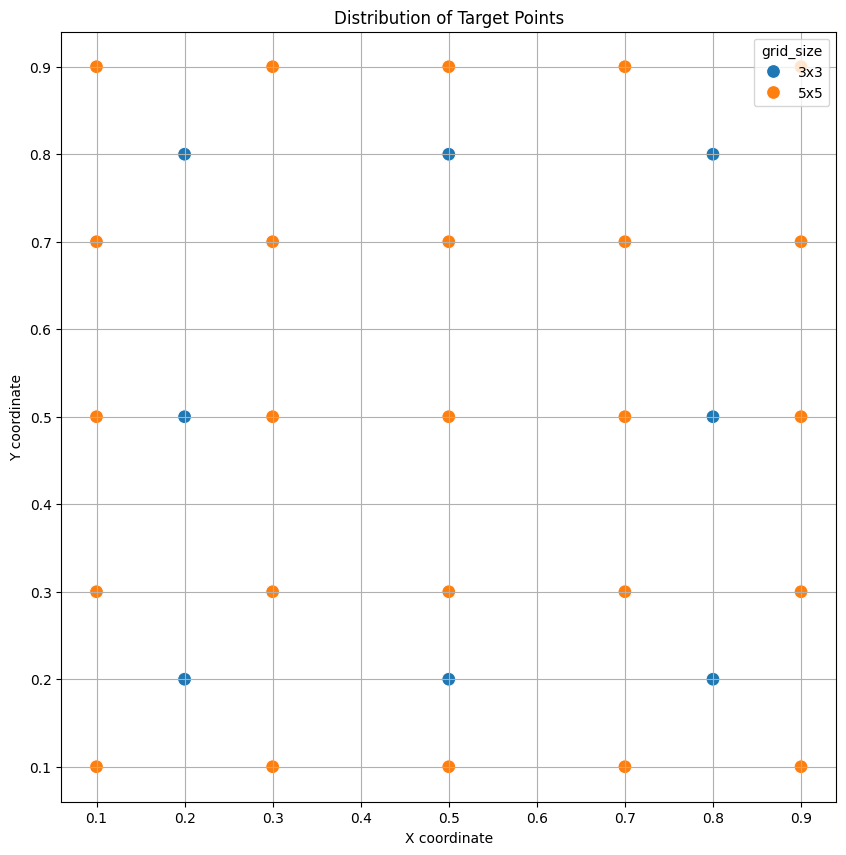

In [23]:
# Plot the distribution of target points
plt.figure(figsize=(10, 10))
sns.scatterplot(x='point_x', y='point_y', hue='grid_size', data=df, s=100)
plt.title('Distribution of Target Points')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()

In [24]:
# Analyze the number of landmarks - check for data incosistencies

# For full face data 478 landmarks * 3 coords = 1434
df['num_landmarks'] = [len(x) for x in df['landmarks']]
print(df['num_landmarks'].describe())




count    1700.0
mean     1434.0
std         0.0
min      1434.0
25%      1434.0
50%      1434.0
75%      1434.0
max      1434.0
Name: num_landmarks, dtype: float64


Data regrading "z" coordinate is irrelevant and will not be a subject of furher exploration 

In [25]:
# Extract "z" coordinate from landmarks
df['landmarks_2d'] = df['landmarks'].apply(lambda x: np.delete(x.reshape(-1, 3), 2, axis=1).flatten())

# Verify the new shape
print(df['landmarks_2d'].iloc[0].shape)


(956,)


### Further analysis: landmarks corealation to target

In [ ]:
# Check corelation coefficients between landmarks and target points
# Each landmark now has 2 coordinates, so the total number of features is 478 * 2 = 956
landmark_columns = []
for i in range(478):
    landmark_columns.append(f'landmark_{i}_x')
    landmark_columns.append(f'landmark_{i}_y')

landmark_data = pd.DataFrame(df['landmarks_2d'].tolist(), columns=landmark_columns)
correlation_matrix = landmark_data.corrwith(df['point_x']).to_frame(name='correlation_with_point_x')
correlation_matrix['correlation_with_point_y'] = landmark_data.corrwith(df['point_y'])

# Save the correlation matrix to a file
correlation_matrix.to_csv('../correlation_matrix.csv')

# Find the most impactful landmarks for point_x and point_y
# Create a landmark index column
correlation_matrix['landmark_index'] = [i // 2 for i in range(len(correlation_matrix))]

# For each landmark, find the maximum absolute correlation with point_x and point_y
corr_x_abs = correlation_matrix.abs().groupby('landmark_index')['correlation_with_point_x'].max()
corr_y_abs = correlation_matrix.abs().groupby('landmark_index')['correlation_with_point_y'].max()

# Get the indices of the top 10 landmarks for each target coordinate
top_10_x_indices = corr_x_abs.nlargest(10).index
top_10_y_indices = corr_y_abs.nlargest(10).index

# Get the full correlation data for the top landmarks
top_landmarks_x = correlation_matrix[correlation_matrix['landmark_index'].isin(top_10_x_indices)]
top_landmarks_y = correlation_matrix[correlation_matrix['landmark_index'].isin(top_10_y_indices)]

print("Top 10 most impactful landmarks for point_x:")
print(top_landmarks_x)

print("\nTop 10 most impactful landmarks for point_y:")
print(top_landmarks_y)


Top 10 most impactful landmarks for point_x:
Empty DataFrame
Columns: [correlation_with_point_x, correlation_with_point_y, max_corr_x, max_corr_y, landmark_index]
Index: []

Top 10 most impactful landmarks for point_y:
Empty DataFrame
Columns: [correlation_with_point_x, correlation_with_point_y, max_corr_x, max_corr_y, landmark_index]
Index: []
